In [ ]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



LinearRegression
RandomForestRegressor
VotingRegressor
SVR
KNeighborsRegressor
XGBRegressor



In [ ]:
# Load dataset
df = pd.read_csv('/content/Kidney_match_Data.csv')

In [ ]:
df.head()

,Donor_ID,Recipient_ID,Blood_Type_Donor,Blood_Type_Recipient,HLA_Mismatch,Crossmatch_Test,Donor_GFR,Recipient_GFR,Kidney_Size_Donor (cm³),Kidney_Size_Recipient (cm³),Age_Recipient,BMI_Recipient,Urgency_Level,PRA_Level (%),Similarity_Score
0,D001,R001,AB,AB,1,Negative,94.98,48.45,185.46,162.67,60,19.81,Medium,64.48,0.84
1,D002,R002,A,O,5,Negative,118.03,57.24,178.72,175.50,31,30.57,Medium,39.51,0.92
2,D003,R003,B,A,3,Negative,109.28,52.48,179.63,146.94,38,21.59,Medium,71.32,0.93
3,D004,R004,A,AB,2,Negative,103.95,22.37,173.36,191.91,37,32.66,Low,19.92,0.87
4,D005,R005,AB,AB,3,Negative,86.24,32.53,154.21,146.76,39,32.01,Medium,89.02,0.72


#Preprocessing

In [ ]:
# Drop Donor_ID and Recipient_ID columns
df = df.drop(columns=['Donor_ID', 'Recipient_ID'])

In [ ]:
# encoding
categorical_cols = ['Blood_Type_Donor', 'Blood_Type_Recipient', 'Crossmatch_Test', 'Urgency_Level']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [ ]:
# Handle missing values (impute with mean for continuous variables)
imputer = SimpleImputer(strategy='mean')
df[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)', 'Kidney_Size_Recipient (cm³)',
    'Age_Recipient', 'BMI_Recipient', 'PRA_Level (%)']] = imputer.fit_transform(
    df[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)', 'Kidney_Size_Recipient (cm³)',
        'Age_Recipient', 'BMI_Recipient', 'PRA_Level (%)']])

In [ ]:
# Split data into features (X) and target variable (y)
X = df.drop(['Similarity_Score'], axis=1)  # Features
y = df['Similarity_Score']  # Continuous target variable

In [ ]:
# Normalize continuous features
scaler = StandardScaler()
X[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)', 'Kidney_Size_Recipient (cm³)',
    'Age_Recipient', 'BMI_Recipient', 'PRA_Level (%)']] = scaler.fit_transform(
    X[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)', 'Kidney_Size_Recipient (cm³)',
       'Age_Recipient', 'BMI_Recipient', 'PRA_Level (%)']])

In [ ]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize individual regressors
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor()
}

In [ ]:
# Voting Regressor
voting_regressor = VotingRegressor(estimators=list(models.items()))

In [ ]:
# Train Voting Regressor
voting_regressor.fit(X_train, y_train)
y_pred_voting = voting_regressor.predict(X_test)

In [ ]:
# Evaluate metrics for each model
metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics[name] = {"MAE": mae, "R²": r2}

In [ ]:
# Add Voting Regressor to metrics
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)
metrics["Voting Regressor"] = {"MAE": mae_voting, "R²": r2_voting}

In [ ]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics).T

<ipython-input-16-d534c6cc1591>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['MAE'], ax=axes[0], palette="viridis")
<ipython-input-16-d534c6cc1591>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(metrics_df.index, rotation=45)
<ipython-input-16-d534c6cc1591>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['R²'], ax=axes[1], palette="viridis")
<ipython-input-16-d534c6cc1591>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1

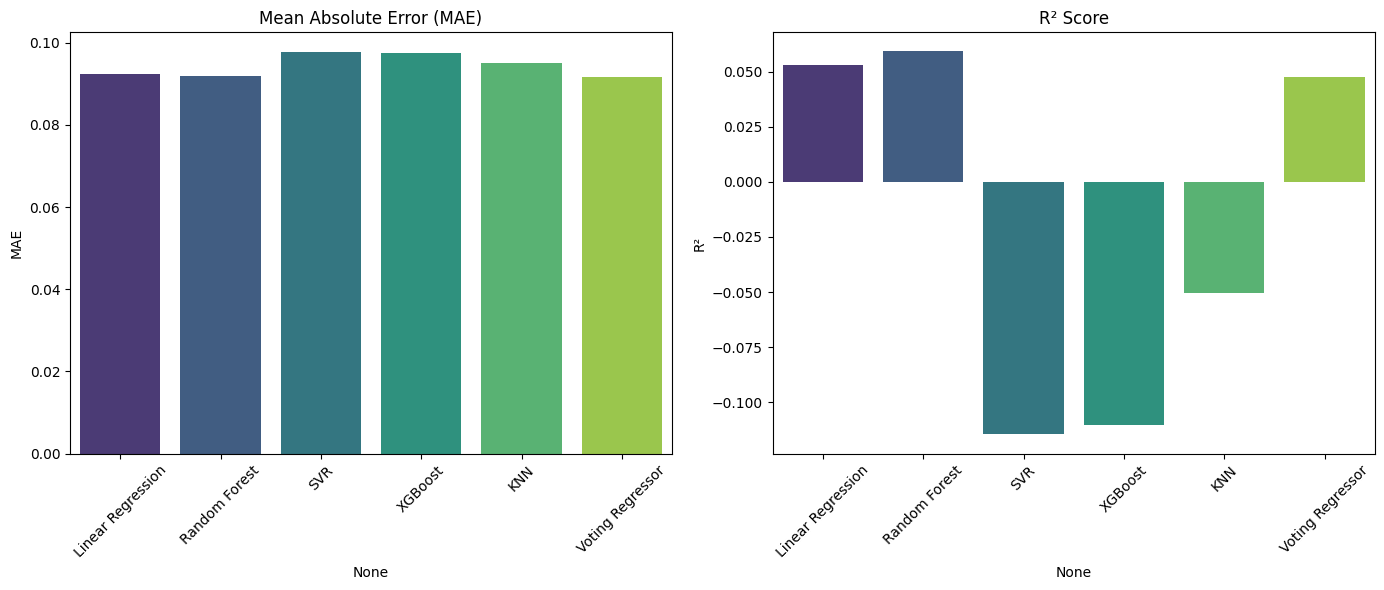

In [ ]:
# Visualize MAE and R² Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MAE
sns.barplot(x=metrics_df.index, y=metrics_df['MAE'], ax=axes[0], palette="viridis")
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_xticklabels(metrics_df.index, rotation=45)
axes[0].set_ylabel("MAE")

# Bar plot for R²
sns.barplot(x=metrics_df.index, y=metrics_df['R²'], ax=axes[1], palette="viridis")
axes[1].set_title("R² Score")
axes[1].set_xticklabels(metrics_df.index, rotation=45)
axes[1].set_ylabel("R²")

plt.tight_layout()
plt.show()


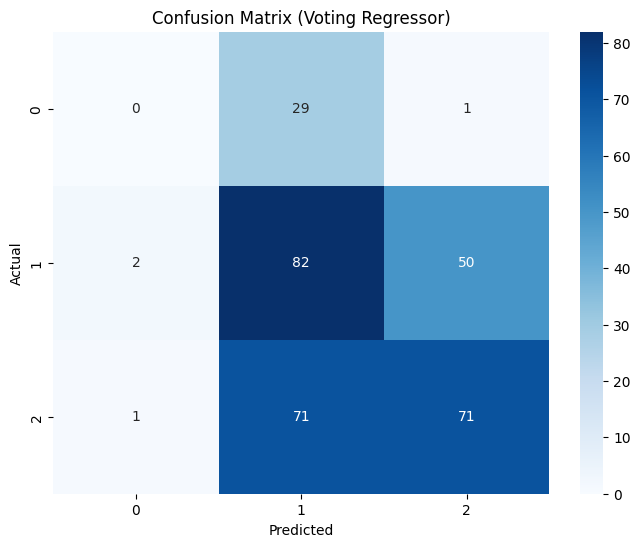

In [ ]:
# Confusion Matrix (Using Voting Regressor)
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_test_binned = kbins.fit_transform(y_test.values.reshape(-1, 1))
y_pred_voting_binned = kbins.transform(y_pred_voting.reshape(-1, 1))

conf_matrix = confusion_matrix(y_test_binned, y_pred_voting_binned)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (Voting Regressor)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<ipython-input-18-022a1e504b18>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")


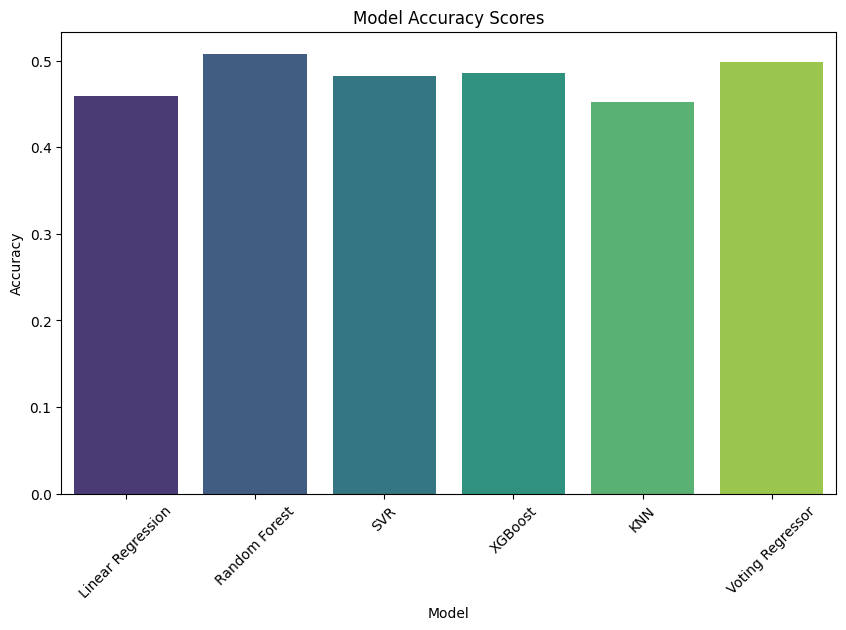

In [ ]:


# Convert continuous values to categories (binning into 3 categories)
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1))
y_test_binned = kbins.transform(y_test.values.reshape(-1, 1))

# Evaluate accuracy for each model
accuracy_scores = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_binned = kbins.transform(y_pred.reshape(-1, 1))
    accuracy = accuracy_score(y_test_binned, y_pred_binned)
    accuracy_scores[name] = accuracy

# Evaluate accuracy for Voting Regressor
y_pred_voting = voting_regressor.predict(X_test)
y_pred_voting_binned = kbins.transform(y_pred_voting.reshape(-1, 1))
accuracy_voting = accuracy_score(y_test_binned, y_pred_voting_binned)
accuracy_scores["Voting Regressor"] = accuracy_voting

# Convert accuracies to DataFrame
accuracy_df = pd.DataFrame(accuracy_scores.items(), columns=['Model', 'Accuracy'])

# Plot Accuracy Scores
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")
plt.title("Model Accuracy Scores")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


In [ ]:
!pip install joblib

In [ ]:
import joblib

In [ ]:
# Save the trained model to a file
joblib.dump(voting_regressor, 'voting_regressor_model.pkl')
print("Model saved as 'voting_regressor_model.pkl'.")

Model saved as 'voting_regressor_model.pkl'.


In [ ]:
# Load the saved model
voting_regressor = joblib.load('voting_regressor_model.pkl')
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:

# Example unseen data
unseen_data = {
    'Blood_Type_Donor': ['A'],
    'Blood_Type_Recipient': ['O'],
    'HLA_Mismatch': [3],
    'Crossmatch_Test': ['Negative'],
    'Donor_GFR': [102.5],
    'Recipient_GFR': [45.8],
    'Kidney_Size_Donor (cm³)': [180.3],
    'Kidney_Size_Recipient (cm³)': [160.2],
    'Age_Recipient': [40],
    'BMI_Recipient': [22.5],
    'Urgency_Level': ['Medium'],
    'PRA_Level (%)': [50.3]
}

In [ ]:
# Convert to DataFrame
unseen_df = pd.DataFrame(unseen_data)

In [ ]:
# Preprocessing for unseen data
categorical_cols = ['Blood_Type_Donor', 'Blood_Type_Recipient', 'Crossmatch_Test', 'Urgency_Level']
for col in categorical_cols:
    le = LabelEncoder()
    unseen_df[col] = le.fit_transform(unseen_df[col])  # Use the same encoding as training

In [ ]:
# Handle missing values (if any)
unseen_df[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)',
           'Kidney_Size_Recipient (cm³)', 'Age_Recipient', 'BMI_Recipient',
           'PRA_Level (%)']] = imputer.transform(unseen_df[['Donor_GFR', 'Recipient_GFR',
                                                            'Kidney_Size_Donor (cm³)',
                                                            'Kidney_Size_Recipient (cm³)',
                                                            'Age_Recipient', 'BMI_Recipient',
                                                            'PRA_Level (%)']])

In [ ]:
# Normalize continuous features
unseen_df[['Donor_GFR', 'Recipient_GFR', 'Kidney_Size_Donor (cm³)',
           'Kidney_Size_Recipient (cm³)', 'Age_Recipient', 'BMI_Recipient',
           'PRA_Level (%)']] = scaler.transform(unseen_df[['Donor_GFR', 'Recipient_GFR',
                                                           'Kidney_Size_Donor (cm³)',
                                                           'Kidney_Size_Recipient (cm³)',
                                                           'Age_Recipient', 'BMI_Recipient',
                                                           'PRA_Level (%)']])


In [ ]:
# Predict the Similarity Score
predicted_similarity_score = voting_regressor.predict(unseen_df)
print("Predicted Similarity Score:", predicted_similarity_score[0])

Predicted Similarity Score: 0.8190612206648609
